# Project 02: Periodicity of Different Stable Electron Orbits
**Name:** Raleigh Fisher

## Introduction

**Research  Question:** How does the periodicity of electron orbits change as its initial velocity and angle are varied, and how can we quantify different classifications of periodicity?

In this project, I investigate how changing the initial velocity and launch angle of an electron affects the periodicity of stable orbits around two protons. The electron has a fixed starting point of (0,1m), with protons at (-1m, 0) and (1m, 0), and solve_ivp is employed to simulate different saturnian-model orbits given an initial velocity v0 and angle $\theta$. Each orbit results in one of three events: The electron collapses into the proton, the electron escapes the orbit altogether, or it becomes bound in some orbit around the proton. I investigate the cases in which the electron remains bound, and how different bound states can be classified by their periodicity as either periodic, quasi-periodic, or chaotic. 

Showing the x/y trajectory of an electron might show an interesting path that remains bound in the specified time frame, but orbits will rarely be perfect ellipses or figure-eights. If this is the case, and they never return to their exact original position, we can't call them truly periodic. However, we might see patterns in their trajectories that tell us that orbits *are* repeating similarly, but may be shifted slightly on each pass. To describe this varying behaviour, we'll plot a *Poincaré section* of the data and assign it a 'Periodicity Score'. Our electron has four properties that are being updated by `solve_ivp`: `x`, `y`, `vx`, and `vy`. Instead of looking at the four-dimensional set, we'll look at just two: `x` and `vx`, and plot a coordinate point (x, vx) every time the electron passes the y=0 plane. For a truly periodic orbit, we would see just a few points, or small clusters of points: this would imply that multiple crossings are stacked on top of each other, meaning the electron returns to its initial position. If the Poincaré section produces a smooth curve of points, we would say that its motion is quasi-periodic: it does somewhat return to its original position, but has almost an 'extra' pattern of motion that it goes through to get there. Finally, chaotic orbits may be identified as 'stable', but produce a cloud of points of some indeterminable pattern. See 'Limitations' for a discussion on how chaos is defined in this project for simplicity.   

Using the Poincaré data, orbit types are classified using a 'Periodicity score', which is the coefficient of variation of the x positions where the electron crosses the y=0 plane.

## Physical Model & Assumptions

Using Coulomb's Law to model the acceleration, where $a = \frac{F}{m}$: $$a = k\frac{q_1 q_2}{m_e r^2}\frac{r}{|r|}$$ And where $k, m_e, q_p = 1$ and $q_e = -1$ for simplicity.

We are using the relative distance of the electron to each proton to get: $$a_i = - \frac{k e^2}{m_e r_i^3} (r - r_i)$$

where $r_i = \sqrt{(x - x_i)^2 + (y - y_i)^2 + {\epsilon}^2}$.  

The total acceleration from each proton is:

$$a_\text{total} = a_1 + a_2$$
Component-wise:

$$a_x = - \frac{k e^2 (x - x_1)}{m_e r_1^3} - \frac{k e^2 (x - x_2)}{m_e r_2^3}, \quad
a_y = - \frac{k e^2 (y - y_1)}{m_e r_1^3} - \frac{k e^2 (y - y_2)}{m_e r_2^3}
$$

Periodicity Score is calculated as the coefficient of variation: 
$$ \frac{\sigma_{x-crossings}}{\mu_{x-crossings}} $$

### Assumptions
1. Poincaré sections were computed using a simplified version of Poincaré mapping [1], where x and vx values were found at each upward crossing at y=0. Only upward crossings were examined, to avoid the collection of two x values close to each other where the electron was travelling in very different directions, therefore possibly misclassifying orbits in the calculation of $\sigma_x$
2. Periodicity score (coefficient of variation[2]) of orbits is calculated using Poincaré section data, and classified as follows:
   - Less than 0.059: Periodic
   - 0.06-0.59: Quasi-periodic
   - Greater than 0.6: Chaotic
3. 'Chaos' is defined by periodicity only, and does not draw from methods in chaos theory; elements such as real analysis, understanding of ODE's & functional analysis are considered as being beyond the scope of this investigation for simplicity
4. A Saturnian model for the electron is assumed. The term 'orbital' in this context describes the shape of the orbit only, and does not refer to spdf notation or orbital shapes based on probability & wavefunctions
5. Collapse distance is taken to be when the electron gets within 0.05m of the proton (or 5% of the initial radius). This accounts for the difference in radius between the proton and the electron, as the simulation assumes both to be point masses. Electrons do not have a truly measurable radius [3], so this radius difference is an approximation by the investigator
6. Escape distance is taken to be 10x the initial radius
7. Bound/stable orbits are established when the electron stays within the escape/collapse bound for the length of the simulation (500s).
8. $k, m_e,$ adn $q$ have all been normalized to 1 for simplicity. This is because the constants act only as scalars of the physical behaviour (acceleration here)
9. Similarly, velocity, radius and timescale are all in units of m/s, m, and s, respectively, as the investigation aims to provide insights into the patterns of behaviour, which have simply been scaled from realistic distances (such as angstroms) and velocities (with orders of magnitude of 10^6). This also limits the computational overhead taken on by the simulation by making the numbers easier to deal with.  

## Simulation Code

## Part I - Visualizing the stable vs unstable orbit phase space

**Code Block Summary:** We begin by importing useful libraries and defining the constants used in the simulation. Into the bulk of the sim, we define velocity and theta (variables), as well as component values for the initial state `(x, y, vx, vy)` of the sim. Functions `collapse_p1`, `collapse_p2`, and `escape` are defined for when the electron collapses into either proton, or when it flies off 10x past the initial radius. The `diff_eqns` function is the heart of the simulation; it takes the initial state and calculates the component accelerations of the electrons from both protons, based on the current position of the electron. Finally, `solve_ivp` is employed to run this simulation and update the four state variables to trace the electron's trajectory. Initially, we use this simulation without plotting; arbitrary `v0` and `theta` are given to facilitate the computation, and a wide range of values is swept to produce a plot showing different outcomes, as detailed below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.collections import LineCollection

# Simplified constants --> change later? 
k = 1.0
e = 1.0
m_e = 1.0
r0 = 1.0

In [62]:
# Initial Conditions
v0 = 1
theta = 1

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_collapse = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_collapse
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_collapse
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2)
    r2 = np.sqrt(dx2**2 + dy2**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 224


**Code Block Summary:** Here, we employ an intermediate function that classifies the simulation results, given a 100x100 grid of initial parameters, as either collapsed, escaped, or bound in some orbit. This classification will allow us to assign values to each outcome, which will appear in three different colours on a heatmap showing the three different simulation outcomes: either the electron escapes, it collapses into a proton, or it remains in some yet-unclassified stable orbit. 

In [63]:
def classify_orbit(v0, theta, t_limit=t_span[1]):

    vx0 = v0 * np.cos(theta)
    vy0 = v0 * np.sin(theta)
    state0_classify = (0, r0, vx0, vy0)

    sol_run = solve_ivp(diff_eqns, (0, t_limit), state0_classify,
                        events=[collapse_p1, collapse_p2, escape],
                        rtol=1e-7, atol=1e-9)
    
    if sol_run.t_events[0].size > 0 or sol_run.t_events[1].size > 0:
        return "collapse"
    elif sol_run.t_events[2].size > 0:
        return "escape"
    else:
        return "bound"

In [64]:
v_values = np.linspace(0.5, 2.0, 100)        
theta_values = np.linspace(0, 2*np.pi, 100) 

# Create an empty 2D array to store results
# 0 = capture, 1 = escape, 2 = bound
results = np.zeros((len(v_values), len(theta_values)))

In [65]:
for i, v0_test in enumerate(v_values):
    for j, theta_test in enumerate(theta_values):
        status = classify_orbit(v0_test, theta_test)
        if status == "collapse":
            results[i, j] = 0
        elif status == "escape":
            results[i, j] = 1
        else:
            results[i, j] = 2

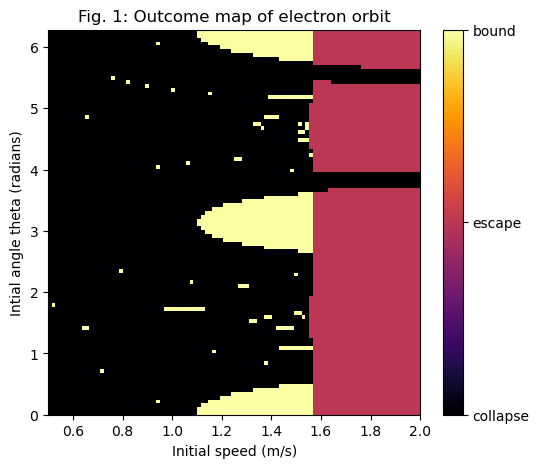

In [66]:
plt.figure(figsize=(6,5))
plt.imshow(results.T, origin='lower',
           extent=[v_values.min(), v_values.max(),
                   theta_values.min(), theta_values.max()],
           aspect='auto', cmap='inferno', vmin=0, vmax=2)
cbar = plt.colorbar(ticks=[0,1,2])
cbar.ax.set_yticklabels(['collapse','escape','bound'])
plt.xlabel('Initial speed (m/s)')
plt.ylabel('Intial angle theta (radians)')
plt.title('Fig. 1: Outcome map of electron orbit')
plt.show()

**Fig. 1: Outcome Map of Electron Orbit** This heatmap shows a discretized spread of 10,000 possible outcomes for the simulation, where we see some interesting patterns emerge. Stable 'wells' appear for velocities from ~1.1-1.6 m/s, for theta values near 0, $\pi$, and $2\pi$, where 0 and $2\pi$ are effectively the same launch angle (the electron is launched directly to the right). Thus, the two half wells at the top and bottom of the map in this range are actually either side of the same well. In the same vein, the well formed near $\theta = \pi$ represents when the electron is launched directly to the left, and we can expect to see similar orbital patterns in these regions. The curved boundaries of these regions show that as velocity increases, within the stable range, the allowed values of theta widen, as the larger velocity of the electron can swing around the proton without the Coulomb acceleration drawing it to Collapse. 

Some other sections of interest include the scattered points of stability within the plot that are difficult to examine physically just from this map; we will examine more closely some notable segments, such as longer 'stripes' visible in the map.

## Part II - Examining Regions of Interest and Classifying them based on Periodicity

### Analysis of Wells

**Code Block Summary:** Let's take a look at our first section of interest concerning stable orbits. Here, all we've done is zoomed into that stable well discussed in Fig. 1 by changing the window using `plt.xlim()` and `plt.ylim()`; this is the visualisation of the boundary we are examining.

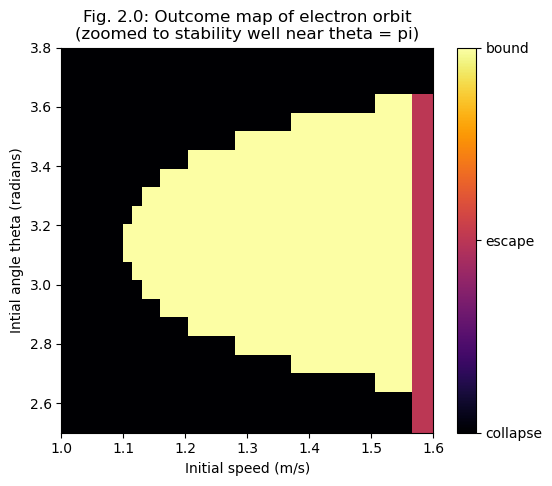

In [67]:
plt.figure(figsize=(6,5))
plt.imshow(results.T, origin='lower',
           extent=[v_values.min(), v_values.max(),
                   theta_values.min(), theta_values.max()],
           aspect='auto', cmap='inferno', vmin=0, vmax=2)
cbar = plt.colorbar(ticks=[0,1,2])
cbar.ax.set_yticklabels(['collapse','escape','bound'])
plt.xlabel('Initial speed (m/s)')
plt.ylabel('Intial angle theta (radians)')
plt.xlim(1.0, 1.6)
plt.ylim(2.5, 3.8)
plt.title('Fig. 2.0: Outcome map of electron orbit\n(zoomed to stability well near theta = pi)')
plt.show()

**Fig 2.0: Outcome map of electron orbit (zoomed to stability well near theta = pi)** Zoomed in region of Fig 1, where we can see the coarser, curved boundary between bound/collapsed orbits, and a clear line between bound/escaped orbits. This follows the physics described in Fig 1.0, and we will perform some analysis on the orbits as we travel from the vertex of the curve & upwards towards the escape boundary. Note that given the symmetry of this region, we can conclude that the top and bottom half of this region (symmetric about theta = $\pi$) will produce mirrored trajectories, and that examining one half of the curve tells us what is happening on the other half.

#### Examining three sections: (1) Towards the vertex of the well, near the boundary, (2) Travelling along the boundary, for increasing v0 and $\theta$, and (3) Towards the middle of the well

**Code Block Summary:** Below, we implement the same simulation code used for the heatmaps, this time with nontrivial initial values for `v0` and `theta`. This analysis is done using a loop that runs all three simulations at the same time. `initial_conditions` is defined to give the set of initial conditions we want to examine,  and a for loop iterates over both an index `idx` (to identify each run) and the initial conditions for each run of the simulation. 

Then, the code in the "Finding y=0 upward crossings" section finds the values of `x` and `vx` where the electron crosses the y=0 plane, stored in the array `crossy0`. From these values, we find the corresponding values of x and vx, where lists `x_cross` and `vx_cross` are filled and converted to arrays to be plotted.

Finally, we plot both the trajectory of the electron as well as the Poincaré section. The trajectory is a 3D plot showing x vs y position, with a gradient colourbar going from lighter to darker as time progresses forwards using the `LineCollection` function in `matplotlib.pyplot`. The Poincaré section is added as a subplot, and `periodicity` is calculated and printed underneath.

[Run 1] Number of time steps = 10949
Run 1 - Periodicity score: 0.069
[Run 2] Number of time steps = 1165
Run 2 - Periodicity score: 0.946
[Run 3] Number of time steps = 5029
Run 3 - Periodicity score: 0.231


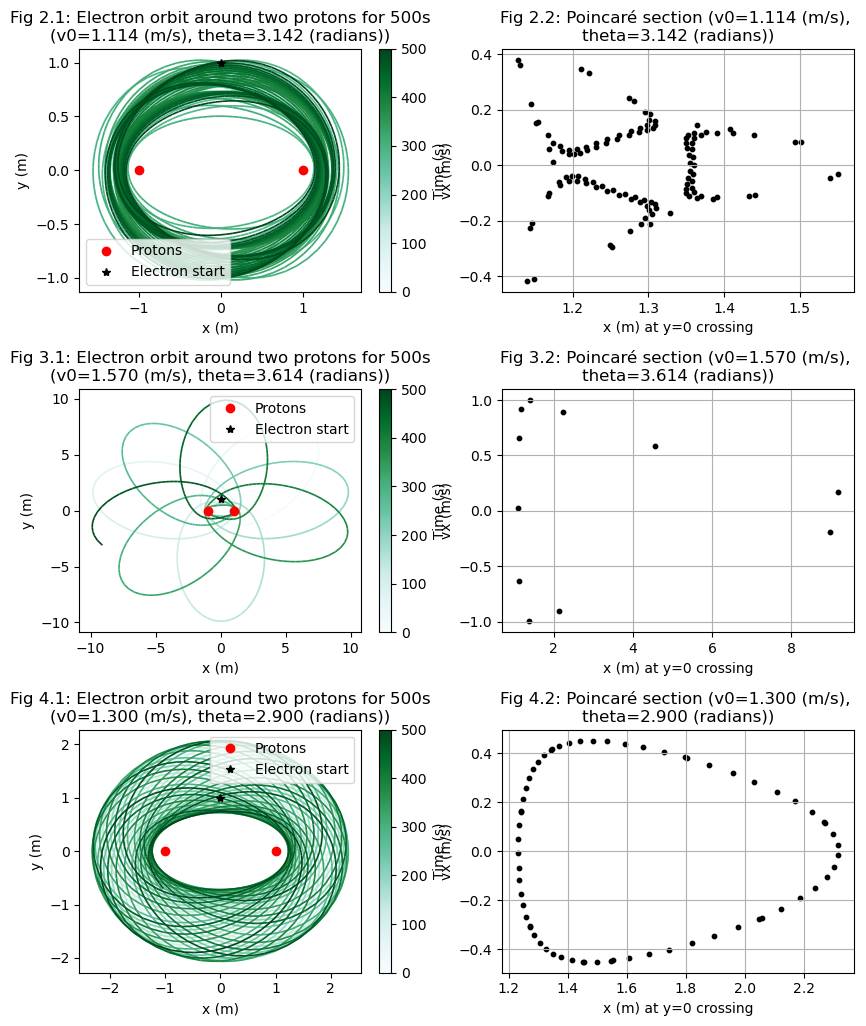

In [3]:
# Three sets of initial conditions
initial_conditions = [(1.114, np.pi), (1.57, 3.614), (1.3, 2.9)]

# Making the multi-panel plot
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.4)

for idx, (v0, theta) in enumerate(initial_conditions):

    # Initial Conditions
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    # Separation between protons
    d = 2*r0 
    
    # Softening distance to avoid accelerations blowing up
    eps = 0.05
    
    t_span = (0, 500)
    state0 = (0, r0, vx, vy)  # x, y, vx, vy
    
    xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
    xp2, yp2 = d/2, 0
    
    r_capture = 0.05 * r0
    R_escape = 10.0 * r0
    
    # Defining events for collapse into either proton/escape
    
    def collapse_p1(t, state):
        x, y = state[0], state[1]
        return np.sqrt((x + d/2)**2 + y**2) - r_capture
        print('The electron collapsed into a proton!')
    collapse_p1.terminal = True
    collapse_p1.direction = -1
    
    def collapse_p2(t, state):
        x, y = state[0], state[1]
        return np.sqrt((x - d/2)**2 + y**2) - r_capture
        print('The electron collapsed into a proton!')
    collapse_p2.terminal = True
    collapse_p2.direction = -1
    
    def escape(t, state):
        x, y = state[0], state[1]
        return np.sqrt(x**2 + y**2) - R_escape
        print('The electron escaped orbit!')
    escape.terminal = True
    escape.direction = 1
    
    # Run simulation
    def diff_eqns(t, state):
        x, y, vx, vy = state
    
        # Coordinates of protons
        x1, y1 = -d/2, 0
        x2, y2 =  d/2, 0
    
        # Distances to each proton
        dx1, dy1 = x - x1, y - y1
        dx2, dy2 = x - x2, y - y2
        r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
        r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)
    
        # Accelerations from each proton
        ax1 = -k * e**2 * dx1 / (m_e * r1**3)
        ay1 = -k * e**2 * dy1 / (m_e * r1**3)
        ax2 = -k * e**2 * dx2 / (m_e * r2**3)
        ay2 = -k * e**2 * dy2 / (m_e * r2**3)
    
        # Total acceleration from both protons
        ax = -(dx1 / r1**3 + dx2 / r2**3)
        ay = -(dy1 / r1**3 + dy2 / r2**3)
        
        return [vx, vy, ax, ay]

    # Solve the system
    sol = solve_ivp(
        diff_eqns, t_span, state0,
        rtol=1e-7, atol=1e-9,
        events=[collapse_p1, collapse_p2, escape]
    )

    print(f"[Run {idx+1}] Number of time steps = {len(sol.t)}")

    x, y, vx_arr, vy_arr = sol.y
    t = sol.t

    # Finding y=0 upward crossings
    crossy0 = np.where((y[:-1] < 0) & (y[1:] > 0))[0]
    x_cross, vx_cross = [], []

    for i in crossy0:
        frac = -y[i] / (y[i+1] - y[i])
        x_cross.append(x[i] + frac * (x[i+1] - x[i]))
        vx_cross.append(vx_arr[i] + frac * (vx_arr[i+1] - vx_arr[i]))

    x_cross = np.array(x_cross)
    vx_cross = np.array(vx_cross)

    # Plotting orbits
    ax1 = axes[idx, 0]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
    lc.set_array(t)
    lc.set_linewidth(1.2)

    line = ax1.add_collection(lc)
    fig.colorbar(line, ax=ax1, label='Time (s)')

    ax1.plot(xp1, yp1, 'ro', label='Protons')
    ax1.plot(xp2, yp2, 'ro')
    ax1.plot(x[0], y[0], '*k', label='Electron start')

    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    ax1.set_title(f'Fig {idx+2}.1: Electron orbit around two protons for 500s\n(v0={v0:.3f} (m/s), theta={theta:.3f} (radians))')
    ax1.legend()

    # Plotting Poincare sections
    ax2 = axes[idx, 1]
    ax2.scatter(x_cross, vx_cross, s=10, c='black')
    ax2.set_xlabel('x (m) at y=0 crossing')
    ax2.set_ylabel('vx (m/s)')
    ax2.set_title(f'Fig {idx+2}.2: Poincaré section (v0={v0:.3f} (m/s), \ntheta={theta:.3f} (radians))')
    ax2.grid(True)

    # Periodicity score for each run
    if len(x_cross) > 2:
        score = np.std(x_cross) / np.mean(np.abs(x_cross))
        print(f"Run {idx+1} - Periodicity score: {score:.3f}")
    else:
        print(f"Run {idx+1} - Not enough crossings for periodicity score")

plt.show()

**Fig 2.1: Electron orbit around two protons for 500s (v0 = 1.114 m/s, theta = pi)** Here we see the simulated orbit for v0 = 1.114 m/s (boundary velocity to 3dp) and theta = $\pi$. This boundary orbit depends on the initial velocity being fast enough to avoid collapse into the nucleus; it follows that boundary orbits here travel much faster, as they are drawn close to the protons from the start. This tight orbit and large acceleration (due to $r^3$ in the Coulomb denominator) create a slightly chaotic yet circular pattern that satisfies the requirements for a stable orbit. 

**Fig 2.2: Poincaré Section\n(v0 = 1.114 m/s, theta = pi)** Poincaré section for v0 = 1.114 and theta = pi. In this plot, we can see three distinct loops, which seem to be outlined by pairs of x-crossings, implying that the electron effectively passed by at each x value twice. These symmetric shapes and pairs of points indicate a quasi-periodic loop, which we confirm numerically using the periodicity score of 0.07. 

**Fig. 3.1: Electron orbit around two protons for 500s (v0 = 1.57 m/s, theta = 3.614 (radians))** Here, the orbit of the electron is plotted for (v0, $\theta$) = (1.57, 3.614), up along the boundary near the highest possible values for theta and v0 in this well. This trajectory shows how the electron follows a much wider path, extending almost past the stable orbit radius due to its high velocity that resists the Coulomb acceleration due to the protons. This wide orbit creates large 'petals' which, while ostensibly symmetric, show how the electron struggles to maintain a periodic orbit.

**Fig. 3.2: Poincaré Section (v0 = 1.57 m/s, theta = 3.614 (radians))** This Poincaré section shows sparse points, which we infer from Fig. 3.1 are not doubled up at all and create an oddly shaped pattern. From the periodicity score of 0.95, we conclude that this orbit is chaotic and is likely not to remain stable over an indefinite period of time. 

**Fig. 4.1: Electron orbit around two protons for 500s (v0 = 1.3 m/s, theta = 2.9 (radians))** Here, an initial value of (v0, $\theta$) = (1.3, 2.9) is used as a trajectory of the electron at a more central point in the stability well. The orbital shape given these parameters can be described as a blend of the two boundary cases we have examined; there are petals traced out, but they are much more overlapped than at the upper boundary, as the velocity does not send it shooting out as far. This allows it to remain close to the proton and establish a more periodic trajectory. 

**Fig. 4.2: Poincaré Section (v0 = 1.3 m/s, theta = 2.9 (radians))** As described in Fig. 4.1, we see how this closer orbit promotes periodicity as the x-crossings are more frequent, and nearer to each other. It is not trivial that more crossings lead to closer crossings, as the smaller orbit allows for the trajectory to nearly repeat itself within the established stable orbit timeframe, up to some standard deviation. The periodicity score of 0.2 reflects this, and places the orbit given by (1.3, 2.9) in the quasi-periodic range

#### Finding a Periodic Orbit

**Code Block Summary:** The following code is the same simulation, run outside of the loop. This orbit is plotted separately as is is less about examining boundaries, but showing an example of a stable orbit and drawing conclusions about the electrons sensitivity to its initial conditions.

In [5]:
# Defining Initial Conditions
v0 = 1.18
theta = np.pi 

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 7665


In [6]:
# Extract solutions
x, y, vx, vy = sol.y
t = sol.t

# Find y=0 crossings
crossy0 = np.where((y[:-1] < 0) & (y[1:] > 0))[0]

# Interpolate the exact crossing points for smoother results
x_cross, vx_cross = [], []
for i in crossy0:
    # Linear interpolation between step i and i+1
    frac = -y[i] / (y[i+1] - y[i])
    x_cross.append(x[i] + frac * (x[i+1] - x[i]))
    vx_cross.append(vx[i] + frac * (vx[i+1] - vx[i]))

# Convert to arrays
x_cross = np.array(x_cross)
vx_cross = np.array(vx_cross)

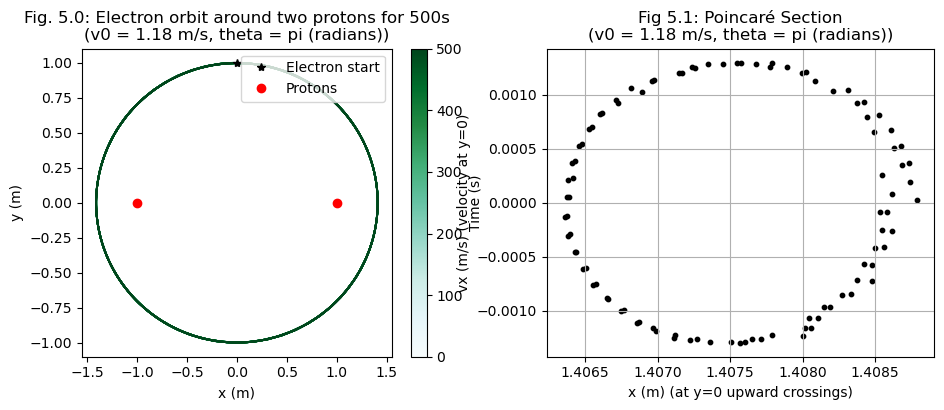

Periodicity score: 0.001


In [7]:
# Plot y vs x

# Extract solution
x, y, t = sol.y[0], sol.y[1], sol.t

# Plot results

# Showing the time dimension using colour
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
lc.set_array(t)
lc.set_linewidth(1.2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))
line = ax1.add_collection(lc)
plt.colorbar(line, ax=ax1, label='Time (s)')

ax1.plot(x[0], y[0], '*k', label='Electron start')
ax1.plot(xp1, yp1, 'ro', label='Protons')
ax1.plot(xp2, yp2, 'ro')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Fig. 5.0: Electron orbit around two protons for 500s\n(v0 = 1.18 m/s, theta = pi (radians))')
ax1.legend()

ax2.scatter(x_cross, vx_cross, s=10, c='black')
ax2.set_xlabel('x (m) (at y=0 upward crossings)')
ax2.set_ylabel('vx (m/s) (velocity at y=0)')
ax2.set_title('Fig 5.1: Poincaré Section\n(v0 = 1.18 m/s, theta = pi (radians))')
ax2.grid(True)

plt.show()

periodicity = np.std(x_cross) / np.mean(np.abs(x_cross))
print(f"Periodicity score: {periodicity:.3f}")

**Fig. 5.0: Electron orbit around two protons for 500s\n(v0 = 1.18 m/s, theta = pi (radians))** Depicted above is a true periodic orbit (Periodicity score $\leq$ 0.059) within the stability well. This orbit is characterized by its narrow trajectory curve (figure proportions depict it as circular, but note that it travels wider along x than along y, making it an ellipse). We can see that it does not deviate far from its original starting position. Truly periodic orbits like these were identified in a range of v0 = 1.123 - 1.232 m/s for $\theta = \pi$, and were maintained within $\theta$ values of approximately $[\pi-0.07, \pi+0.07]$. There is a wider range of periodic velocities than thetas, suggesting that orbital periodicity has a higher sensitivity to launch angle than initial velocity.

**Fig 5.1: Poincaré Section\n(v0 = 1.18 m/s, theta = pi (radians))** Here, the x-crossing and vx points make a loop, deviating slightly from each other for larger x, however, we see that the range of x values where they cross, as well as the velocities they have at those points, are very small (within 0.002). These small deviations contribute to its periodicity score of 0.001, classifying it as a highly periodic stable orbit.

### Analysis of stripes

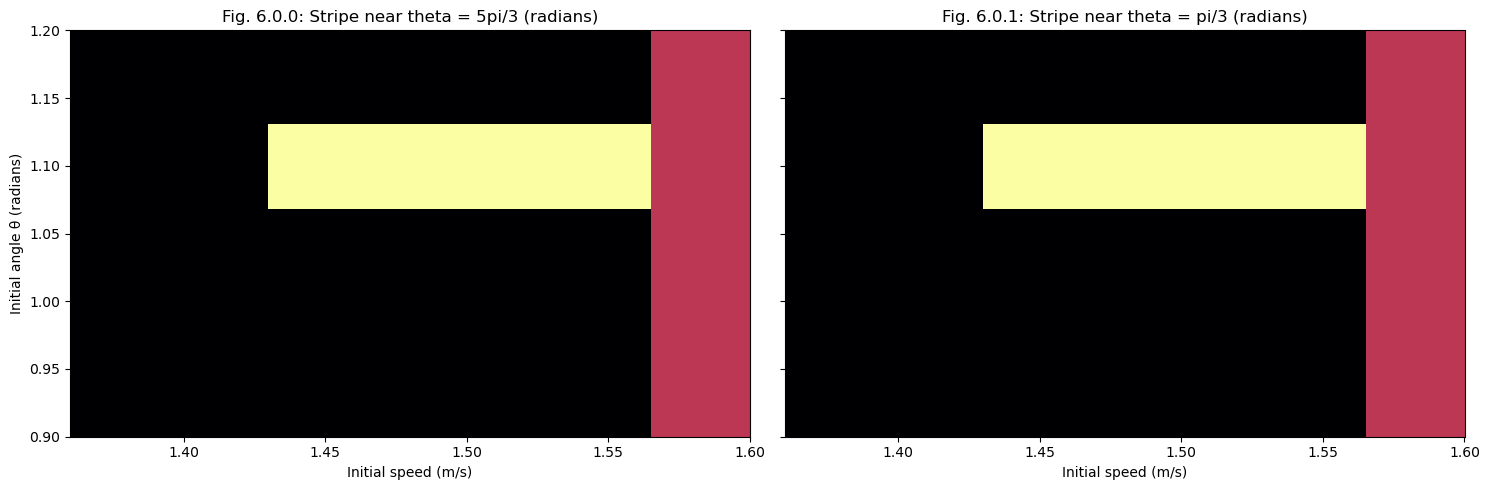

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes):
    im = ax.imshow(
        results.T,
        origin='lower',
        extent=[v_values.min(), v_values.max(),
                theta_values.min(), theta_values.max()],
        aspect='auto',
        cmap='inferno',
        vmin=0, vmax=2
    )

    ax.set_xlabel('Initial speed (m/s)')
    if i == 0:
        ax.set_ylabel('Initial angle θ (radians)')
    
axes[0].set_xlim(1.36, 1.6)   # Region 1
axes[0].set_ylim(5.0, 5.3)
axes[0].set_title('Fig. 6.0.0: Stripe near theta = 5pi/3 (radians)')

axes[1].set_xlim(1.36, 1.6)   # Region 2
axes[1].set_ylim(0.9, 1.2)
axes[1].set_title('Fig. 6.0.1: Stripe near theta = pi/3 (radians)')

plt.tight_layout()
plt.show()

**Figs. 6.0.0 & 6.0.1: Zoomed Regions of Stability Stripes** The three figures above illustrate the stripes seen in the original heatmap at a much closer resolution.

#### Examining the stripes near $\theta \approx \frac{5\pi}{3}$ and $\theta \approx \frac{\pi}{3}$

[Run 1] Number of time steps = 1378
Run 1 - Periodicity score: 1.081
[Run 2] Number of time steps = 1353
Run 2 - Periodicity score: 1.127


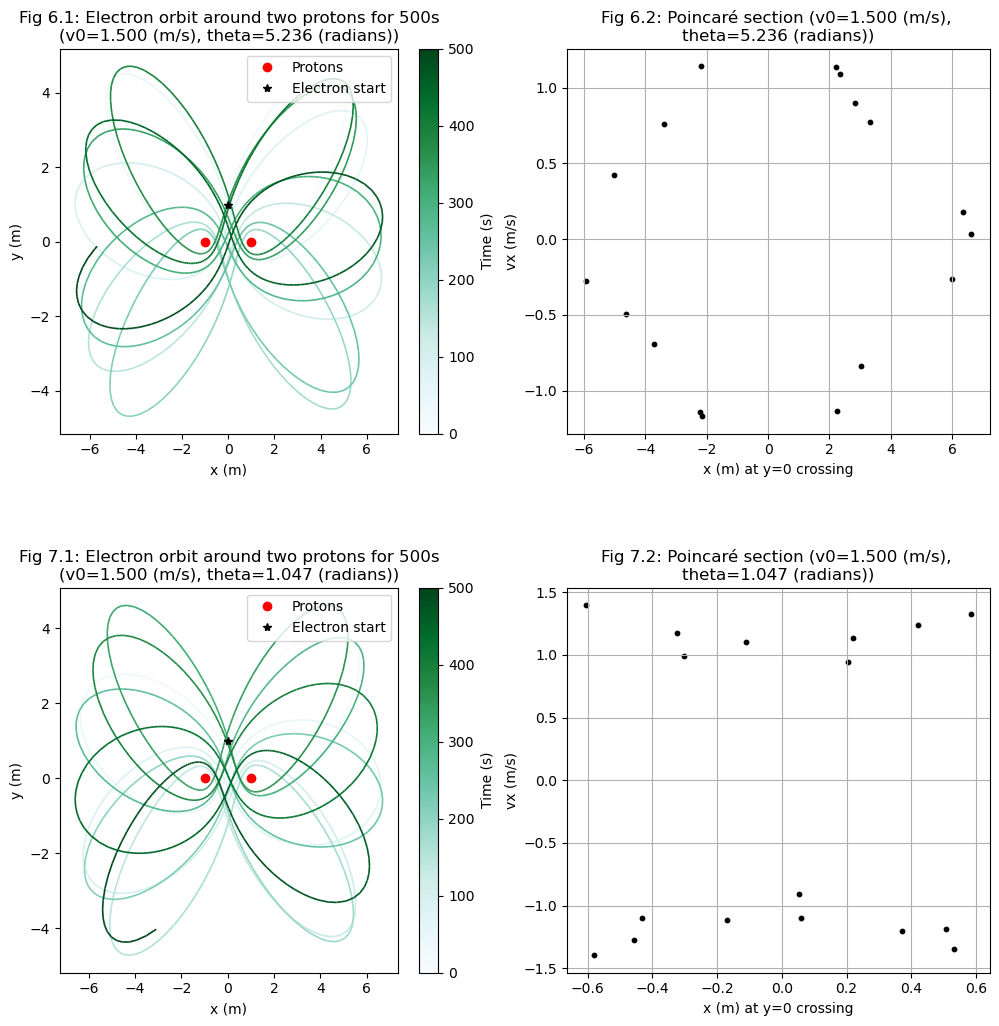

In [8]:
# Three sets of initial conditions
initial_conditions = [(1.5, 5*np.pi/3), (1.5, np.pi/3)]

# Making the multi-panel plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for idx, (v0, theta) in enumerate(initial_conditions):

    # Initial Conditions
    vx = v0 * np.cos(theta)
    vy = v0 * np.sin(theta)

    # Separation between protons
    d = 2*r0 
    
    # Softening distance to avoid accelerations blowing up
    eps = 0.05
    
    t_span = (0, 500)
    state0 = (0, r0, vx, vy)  # x, y, vx, vy
    
    xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
    xp2, yp2 = d/2, 0
    
    r_capture = 0.05 * r0
    R_escape = 10.0 * r0
    
    # Defining events for collapse into either proton/escape
    
    def collapse_p1(t, state):
        x, y = state[0], state[1]
        return np.sqrt((x + d/2)**2 + y**2) - r_capture
        print('The electron collapsed into a proton!')
    collapse_p1.terminal = True
    collapse_p1.direction = -1
    
    def collapse_p2(t, state):
        x, y = state[0], state[1]
        return np.sqrt((x - d/2)**2 + y**2) - r_capture
        print('The electron collapsed into a proton!')
    collapse_p2.terminal = True
    collapse_p2.direction = -1
    
    def escape(t, state):
        x, y = state[0], state[1]
        return np.sqrt(x**2 + y**2) - R_escape
        print('The electron escaped orbit!')
    escape.terminal = True
    escape.direction = 1
    
    # Run simulation
    def diff_eqns(t, state):
        x, y, vx, vy = state
    
        # Coordinates of protons
        x1, y1 = -d/2, 0
        x2, y2 =  d/2, 0
    
        # Distances to each proton
        dx1, dy1 = x - x1, y - y1
        dx2, dy2 = x - x2, y - y2
        r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
        r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)
    
        # Accelerations from each proton
        ax1 = -k * e**2 * dx1 / (m_e * r1**3)
        ay1 = -k * e**2 * dy1 / (m_e * r1**3)
        ax2 = -k * e**2 * dx2 / (m_e * r2**3)
        ay2 = -k * e**2 * dy2 / (m_e * r2**3)
    
        # Total acceleration from both protons
        ax = -(dx1 / r1**3 + dx2 / r2**3)
        ay = -(dy1 / r1**3 + dy2 / r2**3)
        
        return [vx, vy, ax, ay]

    # Solve the system
    sol = solve_ivp(
        diff_eqns, t_span, state0,
        rtol=1e-7, atol=1e-9,
        events=[collapse_p1, collapse_p2, escape]
    )

    print(f"[Run {idx+1}] Number of time steps = {len(sol.t)}")

    x, y, vx_arr, vy_arr = sol.y
    t = sol.t

    # Finding y=0 upward crossings
    crossy0 = np.where((y[:-1] < 0) & (y[1:] > 0))[0]
    x_cross, vx_cross = [], []

    for i in crossy0:
        frac = -y[i] / (y[i+1] - y[i])
        x_cross.append(x[i] + frac * (x[i+1] - x[i]))
        vx_cross.append(vx_arr[i] + frac * (vx_arr[i+1] - vx_arr[i]))

    x_cross = np.array(x_cross)
    vx_cross = np.array(vx_cross)

    # Plotting orbits
    ax1 = axes[idx, 0]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
    lc.set_array(t)
    lc.set_linewidth(1.2)

    line = ax1.add_collection(lc)
    fig.colorbar(line, ax=ax1, label='Time (s)')

    ax1.plot(xp1, yp1, 'ro', label='Protons')
    ax1.plot(xp2, yp2, 'ro')
    ax1.plot(x[0], y[0], '*k', label='Electron start')

    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')
    ax1.set_title(f'Fig {idx+6}.1: Electron orbit around two protons for 500s\n(v0={v0:.3f} (m/s), theta={theta:.3f} (radians))')
    ax1.legend()

    # Plotting Poincare sections
    ax2 = axes[idx, 1]
    ax2.scatter(x_cross, vx_cross, s=10, c='black')
    ax2.set_xlabel('x (m) at y=0 crossing')
    ax2.set_ylabel('vx (m/s)')
    ax2.set_title(f'Fig {idx+6}.2: Poincaré section (v0={v0:.3f} (m/s), \ntheta={theta:.3f} (radians))')
    ax2.grid(True)

    # Periodicity score for each run
    if len(x_cross) > 2:
        score = np.std(x_cross) / np.mean(np.abs(x_cross))
        print(f"Run {idx+1} - Periodicity score: {score:.3f}")
    else:
        print(f"Run {idx+1} - Not enough crossings for periodicity score")

plt.show()

**Fig. 6.1: Electron orbit around two protons for 500s (v0 = 1.5 m/s, theta = 5pi/3 (radians))** Trajectory of electron orbit given (v0, $\theta$) = (1.5, $\frac{5\pi}{3}$). This trajectory sends the electron between the protons, rather than just around them, and traces out a 'butterfly' pattern. The loops in this pattern are much less symmetrical, and while close together, indicate difficulty for the electron to establish a periodic orbit. This makes sense, as the added element of passing between the protons at an angle causes much less predictable accelerations and leads to more complex paths.

**Fig 6.2: Poincaré Section (v0 = 1.5 m/s, theta = 5pi/3 (radians))** While this plot shows a diamond-shaped pattern in x-crossings, we can see that the points outlining this diamond are not symmetric; this shows how the x-velocity at each crossing is different every time, and is reflected in the periodicity score of 1.08. This reinforces conclusions made about Fig. 2.11, where the more complex path leads to a chaotic orbital pattern.

**Fig. 7.1: Electron orbit around two protons for 500s (v0 = 1.5 m/s, theta = pi/3 (radians))** Trajectory of electron for (v0, $\theta$) = (1.5, $\frac{\pi}{3}$). For this trajectory, we see a similar butterfly pattern to the previous case of $\theta = \frac{5\pi}{3}$. However, instead of initially shooting through the protons, it travels up and around before looping back through them. The 'wings' of the butterfly are somewhat more symmetric; however, they still show discrepancies, especially between the protons, which could be what causes the chaotic classification of the orbit.

**Fig 7.2: Poincaré Section (v0 = 1.5 m/s, theta = pi/3 (radians))** While the trajectory may follow the same shape as in Fig. 2.11, we see large differences reflected in the Poincaré section. These crossings have the shape of a hyperbola, and while they seem symmetric, we see the same discrepancies between values of x and vx at each point. This orbit has a periodicity score of 1.13, indicating a greater degree of chaos compared to the previous case. This did not align with my expectations, as I expected the periodicity scores for this case and the case of $\theta = \frac{5\pi}{3}$ to be roughly the same. However, the electron passing between the protons creates a much more complex path and suggests a large sensitivity with regards to values of $\theta$.

## Part III - Plots showing escaped & collapsed orbits

### Escaped orbit

In [9]:
# Defining Initial Conditions
v0 = 1.58
theta = np.pi / 3

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 27


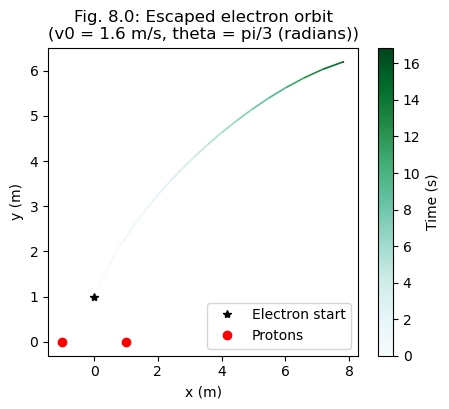

In [12]:
# Plot y vs x

# Extract solution
x, y, t = sol.y[0], sol.y[1], sol.t

# Plot results

# Showing the time dimension using colour
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
lc.set_array(t)
lc.set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(5,4))
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax, label='Time (s)')

ax.plot(x[0], y[0], '*k', label='Electron start')
ax.plot(xp1, yp1, 'ro', label='Protons')
ax.plot(xp2, yp2, 'ro')

# Axis and labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Fig. 8.0: Escaped electron orbit\n(v0 = 1.6 m/s, theta = pi/3 (radians))')
ax.legend(loc='lower right')
plt.show()

**Fig 8.0 Escaped electron orbit (v0 = 1.6 m/s, theta = pi/3):** Case where the initial velocity is too great such that its launch angle allows it to escape orbit. This case follows behaviour as shown in in the initial phase-space heatmap where velocities greater than ~1.6 m/s do not lead to a stable orbit. This was expected, as the escape velocity is within the same small range for most value of theta. Exceptions to this would be the two black 'legs' denoting collapse into a proton, where the initial angle shoots the electron directly towards either proton near values of $\frac{5\pi}{4}$ and $\frac{7\pi}{4}$.

### Collapsed orbit

In [13]:
# Defining Initial Conditions
v0 = 1.0
theta = 4 * np.pi / 3

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 819


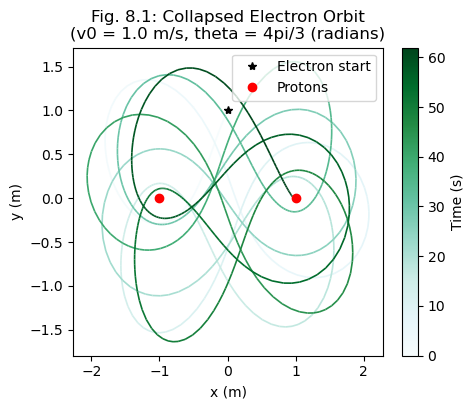

In [14]:
# Plot y vs x

# Extract solution
x, y, t = sol.y[0], sol.y[1], sol.t

# Plot results

# Showing the time dimension using colour
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
lc.set_array(t)
lc.set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(5,4))
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax, label='Time (s)')

ax.plot(x[0], y[0], '*k', label='Electron start')
ax.plot(xp1, yp1, 'ro', label='Protons')
ax.plot(xp2, yp2, 'ro')

# Axis and labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Fig. 8.1: Collapsed Electron Orbit\n(v0 = 1.0 m/s, theta = 4pi/3 (radians)')
ax.legend()
plt.show()

**Fig. 8.1: Collapsed Electron Orbit\n(v0 = 1.0 m/s, theta = 4pi/3** Trajectory of an electron that collapses into a proton before any kind of stable orbit is established. As seen in the previous analysis, the stable orbits examined outside of the well were chaotic, suggesting a high risk of collapse over an indefinite period of time. This trajectory represents one of many that collapse very quickly, before stability is reached.

## Summary of Results and Conclusion

In this project, I investigated how varying two initial parameters, initial velocity and launch angle, affects the periodicity of stable orbits for an electron around two protons. Orbits were initially classified as either stable, escaped, or collapsed; stable orbits were analyzed and classified further as either periodic (periodicity score < 0.059), quasi-periodic (periodicity score between 0.06 - 0.59) or chaotic (periodicity score > 0.59). By investigating three regions of interest from a sweep of 10,000 possible outcomes--stable wells and stable stripes--I found that while stable orbits are sensitive to a small range of initial velocities, they are far more sensitive to initial launch angle. 

In the stable wells, I investigated behaviour along the collapse/escape boundaries as well as towards the central region of the well; orbits near the boundary where $\theta$ was close to $\pi$ (electron shooting straight to the left, mirroring behaviour for $\theta = 0$), orbits were quasi-periodic. Poincaré sections showed pattered x/vx crossings of y=0, and leaned slightly towards the chaotic range of periodicity score. Travelling along the boundary, where $\theta$ and v0 increased more, orbits transitioned to fully chaotic. However, when v0 was kept near the escape boundary but $\theta$ was brought back near $\pi$, orbits shifted more into the quasi-periodic range. A range of true periodic orbits was found, for $\theta = \pi$ within $\pm$ 0.07, and a larger velocity range of v0 = 1.125 and 1.232 m/s.

In the stable stripes, near $\theta = \frac{\pi}{3}$ and $\theta = \frac{5\pi}{3}$, I found that the electron's trajectory would pass between the protons in warped figure eights, creating butterfly-like patterns. These patterns, while stable, were classified as chaotic due to their high periodicity scores, and furthered my conclusions that the electrons' periodicity was highly sensitive to launch angle. These chaotic orbits showed large variations in x and vx in their Poincaré sections, showing that the electron struggled to repeat a trajectory in the given stable time frame. 

## Limitations and Next Steps

There are several limitations to the project. The heatmap sweep of outcomes, while useful for streamlining the investigation of larger stable orbit areas and boundaries, showed some fairly random points classified as stable; however, these points were not reflected across $\theta = \pi$ like the stable wells or stripes, leading me to believe that there were some errors in the sweep that produced some incorrect outcomes, and were deemed unreliable as regions for analysis. This was difficult to discern, however, as I was restricted to methods of manually zooming in on regions of interest rather than an automated identification of regions of interest. Further, the heatmap resolution, while sweeping 10,000 outcomes, was still fairly coarse; however, I was restricted by computing time as the 100x100 grid took around 15 minutes to process. A smoother spread of outcomes could have made for a more robust boundary analysis. In the same vein, I was limited to manual analysis of each region, thereby limiting the scope of my investigation due to an inability to automate an even spread of test cases.

Next steps would include refining the classification method of periodicity score, figuring out a way to systematically examine more regions of stability, and producing a second heatmap with this more robust dataset, where the stable regions of the initial heatmap were reproduced in three more colours, showing how each region was classified as either periodic, quasi-periodic, or chaotic. These were all attempted at different points in the investigation; however, the methods I tried did not work, and attempting to troubleshoot led me down paths far beyond my knowledge base in this course.

## Acknowledgements

- GenAI used to add the time dimension as line colour for the electron orbital plot
- GenAI helped define even functions, specifically implementing `collapse_p1.terminal = True` and
`collapse_p1.direction = -1`
- GenAI used to help sweep initial parameters to be plotted in the heatmap
- GenAI suggested Poincaré sections as a method of analysis
- GenAI helped build the identification code for related x and vx values after y=0 upward crossings were identified
- GenAI helped plot subplots when one of the subplots had an additional colourbar associated with it
- Gen AI helped set up the loop using the index and the list of initial parameters

## References

[1] https://statisticsbyjim.com/basics/coefficient-variation/
\
[2] https://ocw.mit.edu/courses/12-006j-nonlinear-dynamics-chaos-fall-2022/mit12_006jf22_lec15-16.pdf
\
[3] https://en.wikipedia.org/wiki/Classical_electron_radius

## Appendix 1: Code validation

### A1.1:

To validate my conclusions that the two wells displayed in the intial phase-space sweep would show mirroreed behaviour, I plot trajectories given by the sim at (1.2, 0) and (1.2, $\pi$). You can also see the mirroring based on where the electron stops in its trajectory.

##### Simulation code for (1.2, 0) (Hidden for ease of comparison) 

In [15]:
# Defining Initial Conditions
v0 = 1.2
theta = 0

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 6858


##### Plot for (1.2, 0)

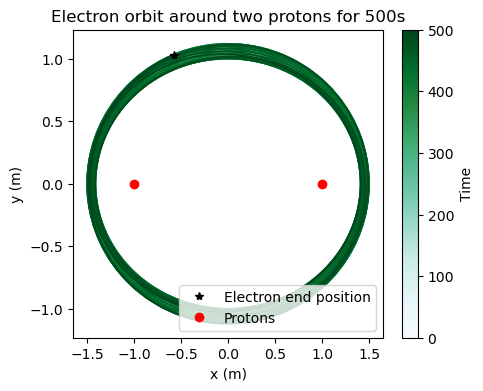

In [16]:
# Plot y vs x

# Extract solution
x, y, t = sol.y[0], sol.y[1], sol.t

# Plot results

# Showing the time dimension using colour
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
lc.set_array(t)
lc.set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(5,4))
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax, label='Time')

ax.plot(x[-1], y[-1], '*k', label='Electron end position')
ax.plot(xp1, yp1, 'ro', label='Protons')
ax.plot(xp2, yp2, 'ro')

# Axis and labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Electron orbit around two protons for 500s')
ax.legend(loc='lower right')
plt.show()

##### Simulation code for (1.2, $\pi$) (Hidden for ease of comparison)

In [17]:
# Defining Initial Conditions
v0 = 1.2
theta = np.pi

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 6858


##### Plot for (1.2, $\pi$)

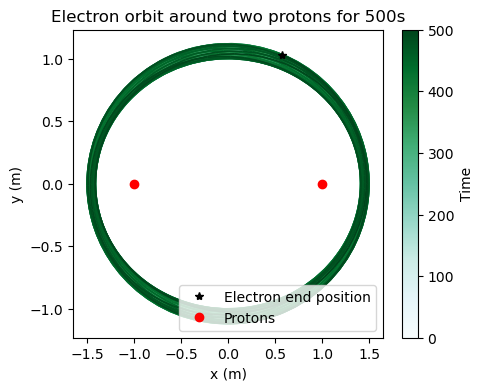

In [20]:
# Plot y vs x

# Extract solution
x, y, t = sol.y[0], sol.y[1], sol.t

# Plot results

# Showing the time dimension using colour
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap='BuGn', norm=plt.Normalize(t.min(), t.max()))
lc.set_array(t)
lc.set_linewidth(1.2)

fig, ax = plt.subplots(figsize=(5,4))
line = ax.add_collection(lc)
plt.colorbar(line, ax=ax, label='Time')

ax.plot(x[-1], y[-1], '*k', label='Electron end position')
ax.plot(xp1, yp1, 'ro', label='Protons')
ax.plot(xp2, yp2, 'ro')

# Axis and labels
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Electron orbit around two protons for 500s')
ax.legend(loc='lower right')
plt.show()

### A1.2: 

Then, I validated the stability of my orbits by plotting kinetic, potential, and total energy vs time to show that kinetic and potential energies oscillate while total energy remains constant. Here, energies are plotted for (v0, $\theta$) = (1.5, $\frac{5\pi}{3}$)

##### Sim code hidden for readability

In [33]:
# Defining Initial Conditions
v0 = 1.5
theta = 5 * np.pi / 3

vx = v0 * np.cos(theta)
vy = v0 * np.sin(theta)

# Separation between protons
d = 2*r0 

# Softening distance to avoid accelerations blowing up
eps = 0.05

t_span = (0, 500)
state0 = (0, r0, vx, vy)  # x, y, vx, vy

xp1, yp1 = -d/2, 0  # Defining proton positions outside of the sim to plot them later
xp2, yp2 = d/2, 0

r_capture = 0.05 * r0
R_escape = 10.0 * r0

# Defining events for collapse into either proton/escape

def collapse_p1(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x + d/2)**2 + y**2) - r_capture
collapse_p1.terminal = True
collapse_p1.direction = -1

def collapse_p2(t, state):
    x, y = state[0], state[1]
    return np.sqrt((x - d/2)**2 + y**2) - r_capture
collapse_p2.terminal = True
collapse_p2.direction = -1

def escape(t, state):
    x, y = state[0], state[1]
    return np.sqrt(x**2 + y**2) - R_escape
    
escape.terminal = True
escape.direction = 1

# Run simulation
def diff_eqns(t, state):
    x, y, vx, vy = state

    # Coordinates of protons
    x1, y1 = -d/2, 0
    x2, y2 =  d/2, 0

    # Distances to each proton
    dx1, dy1 = x - x1, y - y1
    dx2, dy2 = x - x2, y - y2
    r1 = np.sqrt(dx1**2 + dy1**2 + eps**2)
    r2 = np.sqrt(dx2**2 + dy2**2 + eps**2)

    # Accelerations from each proton
    ax1 = -k * e**2 * dx1 / (m_e * r1**3)
    ay1 = -k * e**2 * dy1 / (m_e * r1**3)
    ax2 = -k * e**2 * dx2 / (m_e * r2**3)
    ay2 = -k * e**2 * dy2 / (m_e * r2**3)

    # Total acceleration from both protons
    ax = -(dx1 / r1**3 + dx2 / r2**3)  # This is just ax1 and ax2 added together. Constants are 1 so I omitted them here
    ay = -(dy1 / r1**3 + dy2 / r2**3)
    
    return [vx, vy, ax, ay]

# Solve using solve_ivp
sol = solve_ivp(diff_eqns, t_span, state0, rtol=1e-7, atol=1e-9, events=[collapse_p1, collapse_p2, escape])
print(f"Number of time steps = {len(sol.t)}")

Number of time steps = 1378


##### Energy vs Time

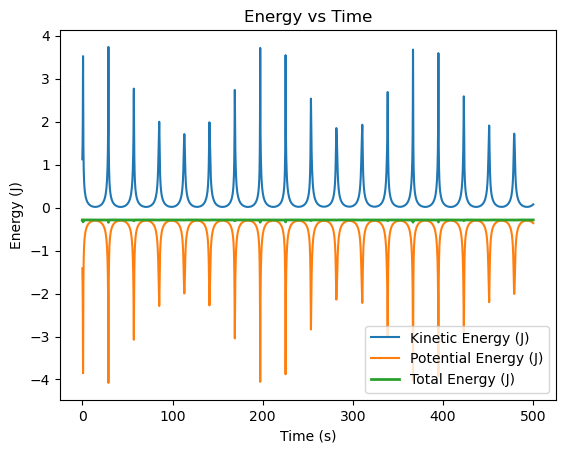

In [34]:
x, y = sol.y[0], sol.y[1]
vx, vy = sol.y[2], sol.y[3]
t = sol.t

# Defining radius outside of sim
r1 = np.sqrt((x - xp1)**2 + (y - yp1)**2)
r2 = np.sqrt((x - xp2)**2 + (y - yp2)**2)

# Energies
Ek = 0.5 * m_e * (vx**2 + vy**2)
Ep = -k * e**2 * (1/r1 + 1/r2)
Etotal = Ek + Ep

# energy vs time
plt.plot(t, Ek, label='Kinetic Energy (J)', color='tab:blue')
plt.plot(t, Ep, label='Potential Energy (J)', color='tab:orange')
plt.plot(t, Etotal, label='Total Energy (J)', color='tab:green', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Energy (J)')
plt.title('Energy vs Time')
plt.legend()

## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

This project took me well beyond my comfort zone in terms of coding. I became much more confortable using solve_ivp and the different things it accepts as arguments, such as events defined by functions that stop the simultation if they are triggered, using tolerances, and what it means for variables to be 'locally defined' vs 'globally defined'. In terms of plotting, I learned about matplotlib's LineCollection function, and how I can use it to add dimension to my x/y position plots. Adding onto that, a ig challenge was figuring out how to make subplots when one of the plots had a colourbar next to it. The Poincare code was also a big challenge, as I knew how to find the y=0 crossings, but had a lot of failed attempts when trying to plot the associated x and vx values. 

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

I think the simulation itself is really clean. From the Homework 11 Part 2 code, I was able to add the second proton pretty easily, and was slowly able to compress things down to what it is now, which is much more readable than, say, the Euler's method code from project 1. The part of my code that I think requires the most effort would be defining the periodicity score, as described in the next-steps section, and also the heatmap. The resolution of the heatmap was very low, even with 10,000 outcomes plotted. As discussed, I was unable to thoroughly investigate the spotted stable regions due to the suspiciously unmirrored patterns they made. Also, it takes forever to run the cell that sweeps through the arrays of v0 and theta. Not so long that it makes the project difficult to work on, but it does delay me some 10-15 minutes. Overall, the time it takes to generate and the certainty of the outcomes it plots are questionable, and I'd like to learn how to visualize the phase space in a more reliable way. 

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

My physical modelling skills here really benefitted from plotting the heatmap first. Barring the difficulties described above, having a visual of the phase space let me be very intentional with the regions I chose to investigate, and draw quick conclusions (like the two wells being mirrors of each other) to avoid exploring extraneous cases. I was limited by the amount of regions I was able to explore manually, and could have benfitted by some automation in some way, but allowed for an efficient analysis nonetheless.

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

I think my use of Poincaré sections was an interesting way to extend my investigation and was useful given the context. I was really interested in the data analysis process, but some of the options for analysis, such as Fourier transforms or Lyapunov functions, were a bit too far beyond what I was capable of, due to both my mathematical background and time. I was able to understand the concept of Poincaré sections more than anything else, and I feel that for this project, they were a useful tool to visualize the phase-space differently. I think that quantifying the data from the sections could use improvement, as I think a more robust scoring method would more accurately represent the periodicity and allow for better classification. 

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

I feel that the flow of first showing the initial heatmap to visualize the phase space, before delving into the exploration of orbits, put the phase-space aspect of the investigation into more context, rather than plotting some orbits and then showing later where they actually lay in the v0/theta phase space. This was furthered through the reiterated heatmap at zoomed in segments to better visualize the boundary regions and stable orbits. This layout was particularly relevant beacuse of the nature of what I was investigating, which was periodicity. If I had just been investigating whether an orbit was stable, escaped or bound, then having the heatmap later on in the investigation would then have been better to show as a recap. 